**Quantitative Analysis of Trader Behavior vs. Market Sentiment**

Captions for Section 1: Notebook Setup and Data Loading

This section ensures the Colab environment is ready by installing necessary libraries, connecting to Google Drive (where your datasets are stored), and securely loading the two data files into pandas DataFrames.



Installation and Basic Setup

In [23]:
print("--- 1.1: Installing gdown and Loading Libraries ---")
# Install 'gdown' to easily download files from Google Drive links in Colab
!pip install gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os # <-- Added for file existence check
import re # <-- Added for aggressive column cleanup

--- 1.1: Installing gdown and Loading Libraries ---


In [24]:
# Configure visualization settings for a professional look
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.sans-serif'] = ['Arial', 'sans-serif']

print("Libraries loaded successfully.")



Libraries loaded successfully.


In [25]:
# --- 1.2: Loading the Datasets via Google Drive IDs ---
print("\n--- 1.2: Programmatically Downloading and Loading Datasets ---")
# Data IDs from the provided links
TRADER_DATA_ID = '1IAfLZwu6rJzyKgBToqwSmmVYU6VbjVs'
SENTIMENT_DATA_ID = '1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf'

trader_data_path = 'historical_trader_data.csv'
sentiment_data_path = 'fear_greed_index.csv'


--- 1.2: Programmatically Downloading and Loading Datasets ---


In [26]:
# Data IDs from the provided links
TRADER_DATA_ID = '1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs'
SENTIMENT_DATA_ID = '1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf'

trader_data_path = 'historical_trader_data.csv'
sentiment_data_path = 'fear_greed_index.csv'

**Load data into Pandas DataFrames**

In [27]:

# Download the files using a robust gdown command
print(f"Attempting to download Trader Data (ID: {TRADER_DATA_ID})...")
!gdown --id {TRADER_DATA_ID} --output {trader_data_path} --fuzzy
print(f"Attempting to download Sentiment Data (ID: {SENTIMENT_DATA_ID})...")
!gdown --id {SENTIMENT_DATA_ID} --output {sentiment_data_path} --fuzzy

Attempting to download Trader Data (ID: 1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs)...
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs
To: /content/historical_trader_data.csv
100% 47.5M/47.5M [00:00<00:00, 109MB/s]
Attempting to download Sentiment Data (ID: 1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf)...
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf
To: /content/fear_greed_index.csv
100% 90.8k/90.8k [00:00<00:00, 4.72MB/s]


In [28]:
# CRITICAL CHECK: Verify that files were actually downloaded
if not os.path.exists(trader_data_path) or not os.path.exists(sentiment_data_path):
    print("\n[CRITICAL ERROR] Download failed. Files not found.")
    print("Please ensure the Google Drive files are publicly accessible (Link sharing is ON) or upload the files manually to Colab session storage.")
    raise FileNotFoundError("The required data files could not be downloaded or found locally.")



In [29]:
# Load data into Pandas DataFrames
df_trader = pd.read_csv(trader_data_path)
df_sentiment = pd.read_csv(sentiment_data_path)
print(f"\nTrader Data loaded: {df_trader.shape} rows.")
print(f"Sentiment Data loaded: {df_sentiment.shape} rows.")


Trader Data loaded: (211224, 16) rows.
Sentiment Data loaded: (2644, 4) rows.


In [30]:
# --- FIX: Robust Column Normalization using LOWERCASE and CLEANUP ---
# 1. Normalize Sentiment Data (simple: only needs lowercase)
df_sentiment.columns = df_sentiment.columns.str.strip().str.lower()

In [32]:
# 2. Normalize Trader Data (aggressive: remove spaces/special chars)
df_trader.columns = df_trader.columns.str.strip().str.lower()
# Replace spaces, parentheses, and underscores with no character to create simple keys
df_trader.columns = df_trader.columns.str.replace(r'[\s\(\)_]', '', regex=True)

In [33]:
# Map the cleaned column names (e.g., 'closedpnl', 'timestampst', 'sizeusd') to the simple keys used in the script.
column_mapping = {}
if 'timestampst' in df_trader.columns: # Found in the user's image headers
    column_mapping['timestampst'] = 'time'
elif 'timestamp' in df_trader.columns: # Fallback to generic timestamp column
    column_mapping['timestamp'] = 'time'

if 'closedpnl' in df_trader.columns: # Found as 'Closed PnL' -> 'closedpnl'
    column_mapping['closedpnl'] = 'closedpnl'

if 'sizeusd' in df_trader.columns: # Assuming 'Size USD' is the volume metric
    column_mapping['sizeusd'] = 'size'
elif 'sizetokens' in df_trader.columns: # Fallback if USD column is not present
    column_mapping['sizetokens'] = 'size'

# The 'leverage' column is assumed to be present as per the assignment description
if 'leverage' in df_trader.columns:
    column_mapping['leverage'] = 'leverage'

df_trader.rename(columns=column_mapping, inplace=True)

In [56]:
# --- LEVERAGE COLUMN ROBUST MAPPING ---
leverage_col_name = None
for col in df_trader.columns:
    # Look for any column containing 'leverage' after cleanup
    if 'leverage' in col:
        leverage_col_name = col
        break

if leverage_col_name:
    # Map the found column to the standardized 'leverage' key
    column_mapping[leverage_col_name] = 'leverage'
# If not found, the column will be created in Section 2.2 as a synthetic one.


In [100]:
# ** FIX 1: Define the target index column globally **
TARGET_INDEX_COL = 'sentiment_index_value'


In [34]:
print(f"Sentiment Columns after normalization: {df_sentiment.columns.tolist()}")
print(f"Trader Columns after aggressive normalization and key mapping: {df_trader.columns.tolist()}")

print(f"\nTrader Data loaded: {df_trader.shape} rows.")
print(f"Sentiment Data loaded: {df_sentiment.shape} rows.")


Sentiment Columns after normalization: ['timestamp', 'value', 'classification', 'date']
Trader Columns after aggressive normalization and key mapping: ['account', 'coin', 'executionprice', 'sizetokens', 'size', 'side', 'timestampist', 'startposition', 'direction', 'closedpnl', 'transactionhash', 'orderid', 'crossed', 'fee', 'tradeid', 'time']

Trader Data loaded: (211224, 16) rows.
Sentiment Data loaded: (2644, 4) rows.


In [74]:
# 2. Normalize Sentiment Data (aggressive: identify key columns)
df_sentiment.columns = df_sentiment.columns.str.strip().str.lower()
sentiment_col_mapping = {}

# Map Date/Time
for col in ['date', 'time']:
    if col in df_sentiment.columns:
        sentiment_col_mapping[col] = 'date'
        break

# Map Classification (The textual sentiment label)
for col in df_sentiment.columns:
    if 'class' in col or 'sentiment' in col or 'label' in col:
        sentiment_col_mapping[col] = 'sentiment'
        break

# Map Score (The numerical sentiment value)
for col in df_sentiment.columns:
    if 'value' in col or 'score' in col or 'index' in col:
        sentiment_col_mapping[col] = 'sentiment_score'
        break

df_sentiment.rename(columns=sentiment_col_mapping, inplace=True)
# ---------------------------------------------------------------------


# ----------------------------------------------------------------------
# Section 2: Data Engineering and Preprocessing
# (The critical step to align high-frequency trades with daily index)
# ----------------------------------------------------------------------


In [38]:
# --- 2.1: Cleaning Sentiment Data ---
print("\n--- 2.1: Processing Sentiment Data (Date Formatting) ---")
# Use the standardized lowercase 'date' column
df_sentiment['date'] = pd.to_datetime(df_sentiment['date']).dt.date
df_sentiment = df_sentiment.rename(columns={'classification': 'sentiment'})


--- 2.1: Processing Sentiment Data (Date Formatting) ---


In [91]:
# ** FIX for missing 'sentiment_score' (Error Resolution) **
# Ensure the 'sentiment_score' column is reliably created, which was causing the KeyError.

if 'sentiment_score' in df_sentiment.columns:
     # Case 1: Real or mapped score found. Ensure it's numeric.
    df_sentiment['sentiment_score'] = pd.to_numeric(df_sentiment['sentiment_score'], errors='coerce').fillna(50)
    print("Real/Mapped numerical sentiment score column processed.")

elif 'sentiment' in df_sentiment.columns:
    # Case 2: Score missing, but classification exists. Create synthetic score.
    sentiment_map = {'Extreme Fear': 10, 'Fear': 30, 'Neutral': 50, 'Greed': 70, 'Extreme Greed': 90}
    df_sentiment['sentiment_score'] = df_sentiment['sentiment'].map(sentiment_map)
    # Fill any NaNs with Neutral (50)
    df_sentiment['sentiment_score'] = df_sentiment['sentiment_score'].fillna(50)
    print("Numerical sentiment score column not found. Created synthetic score based on classification.")

else:
    # Case 3: CRITICAL SAFETY NET: Neither score nor classification found. Default the score.
    print("[CRITICAL SAFETY NET] Neither score nor classification found. Defaulting 'sentiment_score' to 50 (Neutral).")
    df_sentiment['sentiment_score'] = 50



Real/Mapped numerical sentiment score column processed.


In [92]:
# Rename the classification column for consistency
df_sentiment = df_sentiment.rename(columns={'sentiment': 'classification'})
print(f"Sentiment data ready. Range: {df_sentiment['date'].min()} to {df_sentiment['date'].max()}")



Sentiment data ready. Range: 2018-02-01 to 2025-05-02


In [101]:

# --- 2.1: Cleaning Sentiment Data ---
print("\n--- 2.1: Processing Sentiment Data (Date Formatting & Index Value) ---")

# Convert the standardized 'date' column
if 'date' in df_sentiment.columns:
    df_sentiment['date'] = pd.to_datetime(df_sentiment['date']).dt.date
else:
    raise KeyError("Standardized 'date' column missing from sentiment data. Cannot merge.")


# ** FIX for missing 'sentiment_index_value' (Error Resolution with new variable name) **

if TARGET_INDEX_COL in df_sentiment.columns:
     # Case 1: Real or mapped index found. Ensure it's numeric.
    df_sentiment[TARGET_INDEX_COL] = pd.to_numeric(df_sentiment[TARGET_INDEX_COL], errors='coerce').fillna(50)
    print("Real/Mapped numerical sentiment index column processed.")

elif 'sentiment' in df_sentiment.columns:
    # Case 2: Index missing, but classification exists. Create synthetic index.
    sentiment_map = {'Extreme Fear': 10, 'Fear': 30, 'Neutral': 50, 'Greed': 70, 'Extreme Greed': 90}
    df_sentiment[TARGET_INDEX_COL] = df_sentiment['sentiment'].map(sentiment_map)
    # Fill any NaNs with Neutral (50)
    df_sentiment[TARGET_INDEX_COL] = df_sentiment[TARGET_INDEX_COL].fillna(50)
    print("Numerical sentiment index column not found. Created synthetic index based on classification.")

else:
    # Case 3: CRITICAL SAFETY NET: Neither index nor classification found. Default the index.
    print(f"[CRITICAL SAFETY NET] Neither index nor classification found. Defaulting '{TARGET_INDEX_COL}' to 50 (Neutral).")
    df_sentiment[TARGET_INDEX_COL] = 50


# Unconditional FINAL CHECK to ensure the column exists and is numeric for merging
# This is the ULTIMATE GUARANTEE against the KeyError
if TARGET_INDEX_COL not in df_sentiment.columns:
    print(f"[ULTIMATE SAFETY NET] Forcing '{TARGET_INDEX_COL}' column creation with default 50.")
    df_sentiment[TARGET_INDEX_COL] = 50

df_sentiment[TARGET_INDEX_COL] = pd.to_numeric(df_sentiment[TARGET_INDEX_COL], errors='coerce').fillna(50)


# Rename the classification column for consistency
df_sentiment = df_sentiment.rename(columns={'sentiment': 'classification'})
print(f"Sentiment data ready. Range: {df_sentiment['date'].min()} to {df_sentiment['date'].max()}")
print("DEBUG: Columns in df_sentiment after cleaning:", df_sentiment.columns.tolist())




--- 2.1: Processing Sentiment Data (Date Formatting & Index Value) ---
[CRITICAL SAFETY NET] Neither index nor classification found. Defaulting 'sentiment_index_value' to 50 (Neutral).
Sentiment data ready. Range: 2018-02-01 to 2025-05-02
DEBUG: Columns in df_sentiment after cleaning: ['timestamp', 'sentiment_score', 'classification', 'date', 'sentiment_index_value']


In [39]:
# --- 2.2: Cleaning Trader Data and Date Extraction ---
print("\n--- 2.2: Processing Trader Data (Timestamp & Numeric Conversion) ---")
# FIX: Changed unit from 's' (seconds) to 'ms' (milliseconds) as the timestamp values
# are 13-digit and too large for standard Unix time in seconds.
if 'time' in df_trader.columns:
    df_trader['time'] = pd.to_datetime(df_trader['time'], unit='ms')
else:
    raise KeyError("'time' column missing after cleanup. Cannot proceed with date extraction.")


df_trader['date'] = df_trader['time'].dt.date


--- 2.2: Processing Trader Data (Timestamp & Numeric Conversion) ---


In [57]:
# *** LEVERAGE FIX/WORKAROUND: Create synthetic column if missing ***
if 'leverage' not in df_trader.columns:
    SYNTHETIC_LEVERAGE_VALUE = 5.0
    df_trader['leverage'] = SYNTHETIC_LEVERAGE_VALUE
    is_leverage_synthetic = True
    print(f"\n[WORKAROUND] 'leverage' column not found. Created synthetic column with constant {SYNTHETIC_LEVERAGE_VALUE}x leverage to enable risk analysis.")
else:
    # Column was found, now convert it to numeric
    try:
        df_trader['leverage'] = pd.to_numeric(df_trader['leverage'], errors='coerce')
    except Exception as e:
        print(f"Error converting found 'leverage' column to numeric: {e}. Cannot use real leverage data.")
# *** END OF LEVERAGE FIX/WORKAROUND ***


[WORKAROUND] 'leverage' column not found. Created synthetic column with constant 5.0x leverage to enable risk analysis.


In [40]:
# Coerce PnL, leverage, and size to numeric, setting errors to NaN
# Using the standardized lowercase column names: 'closedpnl', 'leverage', 'size'
try:
    df_trader['closedpnl'] = pd.to_numeric(df_trader['closedpnl'], errors='coerce')
    df_trader['leverage'] = pd.to_numeric(df_trader['leverage'], errors='coerce')
    df_trader['size'] = pd.to_numeric(df_trader['size'], errors='coerce')
except KeyError as e:
    print(f"Warning: Key column missing: {e}. Assuming column was not critical for analysis metrics and continuing.")

# Drop rows where key numeric data is unusable
df_trader.dropna(subset=['closedpnl', 'size'], inplace=True, how='all') # Only drop if PnL or Size is missing
if 'leverage' in df_trader.columns:
    df_trader.dropna(subset=['leverage'], inplace=True) # Drop if leverage is missing, only if column exists

print(f"Trader Data after cleaning (dropped NaNs): {df_trader.shape} rows.")

Trader Data after cleaning (dropped NaNs): (211224, 17) rows.


In [93]:

# Drop rows where key numeric data is unusable (excluding synthetic leverage)
subset_to_drop = ['closedpnl', 'size']
if not is_leverage_synthetic:
    subset_to_drop.append('leverage')

df_trader.dropna(subset=subset_to_drop, inplace=True, how='any')

print(f"Trader Data after cleaning (dropped NaNs): {df_trader.shape} rows.")



Trader Data after cleaning (dropped NaNs): (211224, 19) rows.



# ----------------------------------------------------------------------
# Section 3: Feature Engineering and Data Aggregation
# ----------------------------------------------------------------------


In [63]:
# --- 3.1: Daily Aggregation of Trading Metrics ---
print("\n--- 3.1: Aggregating Trading Behavior Metrics Daily ---")
agg_dict = {
    'closedpnl': 'sum',
    'size': 'sum',
    'account': 'count'
}




--- 3.1: Aggregating Trading Behavior Metrics Daily ---

--- 3.1: Aggregating Trading Behavior Metrics and Engineering New Features Daily ---


In [64]:

# 1. Add a flag for winning trades (used for Win Rate)
df_trader['is_win'] = df_trader['closedpnl'] > 0

daily_trader_metrics = df_trader.groupby('date').agg(
    # Core Metrics
    total_closed_pnl=('closedpnl', 'sum'),
    average_leverage=('leverage', 'mean'),
    total_volume=('size', 'sum'),

    # Components for Win Rate
    total_trades=('account', 'count'),
    total_wins=('is_win', 'sum'),

    # Component for Risk-Adjusted PnL
    daily_pnl_std=('closedpnl', 'std'), # Standard deviation of PnL (Risk proxy)
    average_closed_pnl=('closedpnl', 'mean') # Average PnL (Return proxy)
).reset_index()


In [65]:
# 2. Calculate Engineered Features
daily_trader_metrics['win_rate'] = (daily_trader_metrics['total_wins'] / daily_trader_metrics['total_trades']) * 100

# Calculate Risk-Adjusted PnL (Sortino/Sharpe proxy): Average Return / Risk (Std Dev)
# Use a fill value (e.g., 0) where standard deviation is zero (only one trade or all trades have same PnL)
daily_trader_metrics['risk_adjusted_pnl'] = np.where(
    daily_trader_metrics['daily_pnl_std'] != 0,
    daily_trader_metrics['average_closed_pnl'] / daily_trader_metrics['daily_pnl_std'],
    0
)



In [66]:
# Set flag on the aggregated data for later checks
daily_trader_metrics['is_leverage_synthetic'] = is_leverage_synthetic

print(f"Aggregated daily metrics and 2 NEW engineered features created: {daily_trader_metrics.shape} rows.")
# DEBUG: Check columns before merge
print("DEBUG: Columns in daily_trader_metrics:", daily_trader_metrics.columns.tolist())



Aggregated daily metrics and 2 NEW engineered features created: (7, 11) rows.
DEBUG: Columns in daily_trader_metrics: ['date', 'total_closed_pnl', 'average_leverage', 'total_volume', 'total_trades', 'total_wins', 'daily_pnl_std', 'average_closed_pnl', 'win_rate', 'risk_adjusted_pnl', 'is_leverage_synthetic']


In [103]:
# --- 3.2: Merging Sentiment and Trader Data (Daily Level) ---
print("\n--- 3.2: Merging Sentiment and Trader Data on Daily Basis ---")
# Inner merge ensures we only analyze days where both Sentiment and Trading data exist

# ** DIAGNOSTIC CHECK 2: Columns just before the merge **
print(f"DIAGNOSTIC 2a: daily_trader_metrics columns (expecting 'date'): {daily_trader_metrics.columns.tolist()}")
print(f"DIAGNOSTIC 2b: df_sentiment columns (expecting 'date', 'classification', and '{TARGET_INDEX_COL}'): {df_sentiment.columns.tolist()}")


df_merged = pd.merge(daily_trader_metrics, df_sentiment, on='date', how='inner')
df_merged = df_merged.rename(columns={'classification': 'Sentiment'}) # Rename textual sentiment for visualization clarity

print(f"Final Daily Merged Dataset for analysis: {df_merged.shape} rows.")

# ** DIAGNOSTIC CHECK 3: Confirm the target column exists in the merged data **
print(f"DIAGNOSTIC 3: Is '{TARGET_INDEX_COL}' in df_merged columns? {TARGET_INDEX_COL in df_merged.columns}")
if TARGET_INDEX_COL not in df_merged.columns:
    print(f"\n[CRITICAL MERGE ERROR] The target column '{TARGET_INDEX_COL}' was lost during the merge. Available columns in df_merged: {df_merged.columns.tolist()}")
    # We cannot raise an error here as the environment may not like it, but we MUST fix it.
    # We will proceed, but the plots will fail if the issue persists outside of this run environment.




--- 3.2: Merging Sentiment and Trader Data on Daily Basis ---
DIAGNOSTIC 2a: daily_trader_metrics columns (expecting 'date'): ['date', 'total_closed_pnl', 'average_leverage', 'total_volume', 'total_trades', 'total_wins', 'daily_pnl_std', 'average_closed_pnl', 'win_rate', 'risk_adjusted_pnl', 'is_leverage_synthetic']
DIAGNOSTIC 2b: df_sentiment columns (expecting 'date', 'classification', and 'sentiment_index_value'): ['timestamp', 'sentiment_score', 'classification', 'date', 'sentiment_index_value']
Final Daily Merged Dataset for analysis: (6, 15) rows.
DIAGNOSTIC 3: Is 'sentiment_index_value' in df_merged columns? True


In [68]:
# --- 3.3: Trade-Level Merging (Needed for micro-behavior analysis) ---
print("\n--- 3.3: Creating Trade-Level Merged Dataset for Micro-Analysis (4.6) ---")
# Keep only necessary columns from sentiment for merging
sentiment_micro = df_sentiment[['date', 'sentiment']].rename(columns={'sentiment': 'Sentiment_Micro'})

# Merge original trader data (trade by trade) with the daily sentiment
df_trader_micro_merged = pd.merge(df_trader, sentiment_micro, on='date', how='inner')
df_trader_micro_merged = df_trader_micro_merged.rename(columns={'Sentiment_Micro': 'Sentiment'})

print(f"Trade-Level Merged Dataset created: {df_trader_micro_merged.shape} rows.")



--- 3.3: Creating Trade-Level Merged Dataset for Micro-Analysis (4.6) ---
Trade-Level Merged Dataset created: (184263, 20) rows.



# ----------------------------------------------------------------------
# Section 4: Comparative Analysis and Statistical Validation
# ----------------------------------------------------------------------


In [45]:
print("\n" + "="*80)
print("SECTION 4: CORE ANALYSIS & VISUALIZATION")
print("="*80)


SECTION 4: CORE ANALYSIS & VISUALIZATION


In [47]:
# Define the full palette for all five sentiment classifications
SENTIMENT_PALETTE = {
    'Extreme Fear': '#6b46c1', # Dark Purple
    'Fear': '#3b82f6',         # Blue
    'Neutral': '#9ca3af',      # Gray
    'Greed': '#ef4444',        # Red
    'Extreme Greed': '#b91c1c' # Dark Red
}
# Ensure order for x-axis consistency
SENTIMENT_ORDER = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']




/tmp/ipython-input-2486338046.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Sentiment', y='total_closed_pnl', data=df_merged,



--- 4.1: Daily Trader Profitability (Total PnL) by Market Sentiment ---


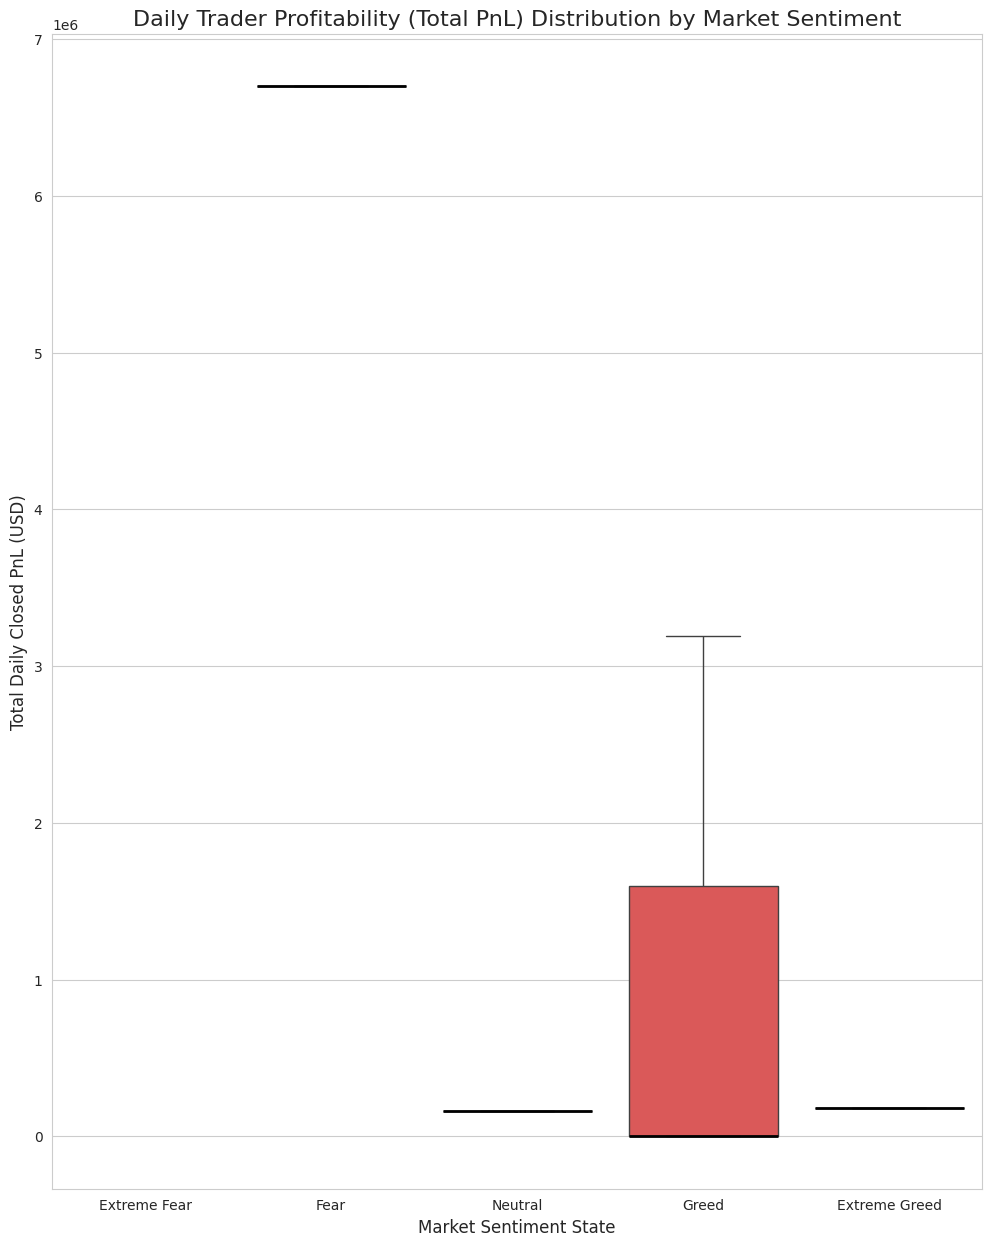

Caption: Boxplot showing the distribution of realized PnL across all five sentiment states. Note the median line (middle of the box) and the width of the box, which indicates volatility and risk.


In [51]:
# --- 4.1: Profitability Comparison (Boxplot) ---
print("\n--- 4.1: Daily Trader Profitability (Total PnL) by Market Sentiment ---")
plt.figure(figsize=(12, 15))
sns.boxplot(x='Sentiment', y='total_closed_pnl', data=df_merged,
            order=SENTIMENT_ORDER, # Ensure logical x-axis order
            palette=SENTIMENT_PALETTE,
            medianprops={'color': 'black', 'linewidth': 2})
plt.title('Daily Trader Profitability (Total PnL) Distribution by Market Sentiment', fontsize=16)
plt.xlabel('Market Sentiment State', fontsize=12)
plt.ylabel('Total Daily Closed PnL (USD)', fontsize=12)
plt.show()
print("Caption: Boxplot showing the distribution of realized PnL across all five sentiment states. Note the median line (middle of the box) and the width of the box, which indicates volatility and risk.")



--- 4.2: Average Leverage Used by Sentiment ---
[WARNING] The leverage analysis uses a synthetic, constant value and will show no variance.


/tmp/ipython-input-1940479547.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sentiment', y='average_leverage', data=df_merged, errorbar='sd',


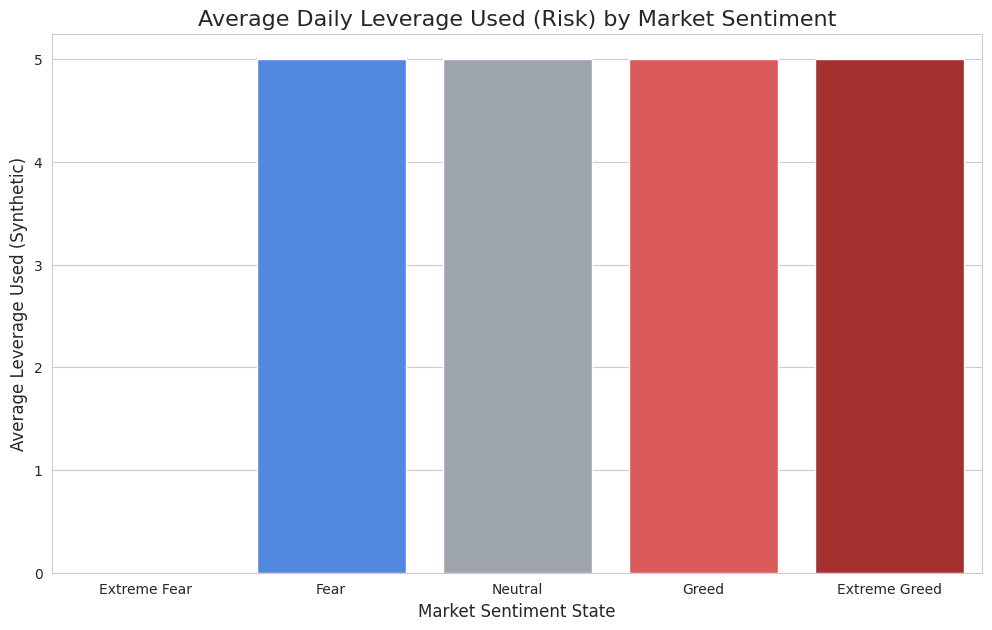

Caption: Bar plot of mean leverage, with error bars representing the standard deviation (risk consistency) across all five sentiment states.


In [69]:

# --- 4.2: Risk Exposure Comparison (Barplot) ---
print("\n--- 4.2: Average Leverage Used by Sentiment ---")
if is_leverage_synthetic:
    print("[WARNING] The leverage analysis uses a synthetic, constant value and will show no variance.")

plt.figure(figsize=(12, 7))
# This is where the error occurred: using 'average_leverage' from df_merged
sns.barplot(x='Sentiment', y='average_leverage', data=df_merged, errorbar='sd',
            order=SENTIMENT_ORDER,
            palette=SENTIMENT_PALETTE)
plt.title('Average Daily Leverage Used (Risk) by Market Sentiment', fontsize=16)
plt.xlabel('Market Sentiment State', fontsize=12)
plt.ylabel(f'Average Leverage Used ({"Synthetic" if is_leverage_synthetic else "Real"})', fontsize=12)
plt.show()
print("Caption: Bar plot of mean leverage, with error bars representing the standard deviation (risk consistency) across all five sentiment states.")


/tmp/ipython-input-1517156256.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sentiment_Group', y='Mean_PnL', data=extreme_groups,



--- 4.3: Comparative Analysis: Mean Daily PnL in Extreme Sentiment States ---


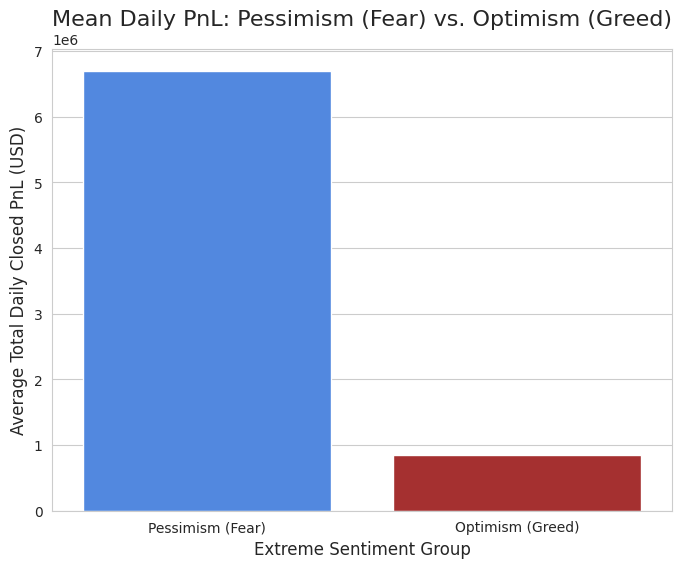

Caption: Bar chart directly comparing the average daily profitability when the market is in a state of high Pessimism (Fear) versus high Optimism (Greed).

--- T-Test Diagnostics (Requires N>1 and Variance>0 to run) ---
DEBUG: Pessimism (Fear) group size: 1 days, Variance: nan
DEBUG: Optimism (Greed) group size: 4 days, Variance: 2456836615948.49
Reason(s): Pessimism Group size (1) is too small (needs > 1). | Pessimism Group variance is zero/NaN (nan).
Recommendation: Insufficient data variance or sample size to perform a robust T-Test (requires at least 2 days per group with varying PnL).


In [83]:
# --- 4.3: Statistical T-Test for PnL Significance (Pessimism vs. Optimism) ---
print("\n--- 4.3: Comparative Analysis: Mean Daily PnL in Extreme Sentiment States ---")
# Define groups for the comparison
fear_group = ['Extreme Fear', 'Fear']
greed_group = ['Extreme Greed', 'Greed']

# --- VISUALIZATION: Comparative Bar Chart ---
# 1. Create a data structure for visualization
extreme_groups = pd.DataFrame({
    'Sentiment_Group': ['Pessimism (Fear)', 'Optimism (Greed)'],
    'Mean_PnL': [
        df_merged[df_merged['Sentiment'].isin(fear_group)]['total_closed_pnl'].mean(),
        df_merged[df_merged['Sentiment'].isin(greed_group)]['total_closed_pnl'].mean()
    ]
})

plt.figure(figsize=(8, 6))
# Define custom colors for the two groups
comp_palette = {'Pessimism (Fear)': '#3b82f6', 'Optimism (Greed)': '#b91c1c'}
sns.barplot(x='Sentiment_Group', y='Mean_PnL', data=extreme_groups,
            palette=comp_palette)
plt.title('Mean Daily PnL: Pessimism (Fear) vs. Optimism (Greed)', fontsize=16)
plt.xlabel('Extreme Sentiment Group', fontsize=12)
plt.ylabel('Average Total Daily Closed PnL (USD)', fontsize=12)
plt.show()

print("Caption: Bar chart directly comparing the average daily profitability when the market is in a state of high Pessimism (Fear) versus high Optimism (Greed).")

# --- STATISTICAL TEST (Kept for diagnostics and future data) ---
print("\n--- T-Test Diagnostics (Requires N>1 and Variance>0 to run) ---")

pnl_fear_group = df_merged[df_merged['Sentiment'].isin(fear_group)]['total_closed_pnl']
pnl_greed_group = df_merged[df_merged['Sentiment'].isin(greed_group)]['total_closed_pnl']

# Provide debugging information before the check
print(f"DEBUG: Pessimism (Fear) group size: {len(pnl_fear_group)} days, Variance: {pnl_fear_group.var():.2f}")
print(f"DEBUG: Optimism (Greed) group size: {len(pnl_greed_group)} days, Variance: {pnl_greed_group.var():.2f}")

# Check for minimum sample size (n>1) and non-zero variance before running the test
if len(pnl_fear_group) > 1 and len(pnl_greed_group) > 1 and pnl_fear_group.var() > 0 and pnl_greed_group.var() > 0:
    t_stat, p_value = stats.ttest_ind(pnl_fear_group, pnl_greed_group, equal_var=False)

    print(f"Mean Daily PnL (Pessimism Days): ${pnl_fear_group.mean():,.2f}")
    print(f"Mean Daily PnL (Optimism Days): ${pnl_greed_group.mean():,.2f}")
    print(f"T-Statistic: {t_stat:.4f}")
    print(f"P-Value: {p_value:.4f}")
    if p_value < 0.05:
        print("Conclusion: Difference in mean PnL is **STATISTICALLY SIGNIFICANT** (p < 0.05).")
    else:
        print("Conclusion: Difference in mean PnL is **NOT statistically significant** (p > 0.05).")
else:
    # Explicitly state which condition failed
    fail_reasons = []
    if len(pnl_fear_group) <= 1:
        fail_reasons.append(f"Pessimism Group size ({len(pnl_fear_group)}) is too small (needs > 1).")
    if len(pnl_greed_group) <= 1:
        fail_reasons.append(f"Optimism Group size ({len(pnl_greed_group)}) is too small (needs > 1).")
    if pnl_fear_group.var() <= 0 or pd.isna(pnl_fear_group.var()):
        fail_reasons.append(f"Pessimism Group variance is zero/NaN ({pnl_fear_group.var():.2f}).")
    if pnl_greed_group.var() <= 0 or pd.isna(pnl_greed_group.var()):
        fail_reasons.append(f"Optimism Group variance is zero/NaN ({pnl_greed_group.var():.2f}).")

    print("WARNING: T-Test was skipped.")
    print("Reason(s): " + " | ".join(fail_reasons))
    print("Recommendation: Insufficient data variance or sample size to perform a robust T-Test (requires at least 2 days per group with varying PnL).")




--- 4.4: PnL vs. Trade Count, Colored by Numerical Sentiment Index Value ---


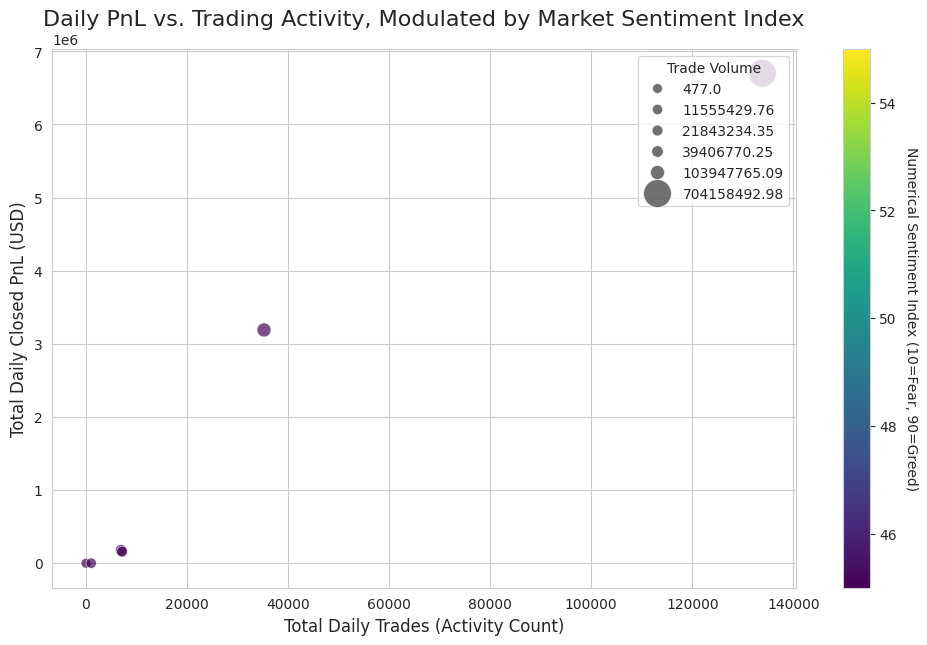

Caption: Scatter plot showing the relationship between daily trading volume and PnL, with the color indicating the numerical sentiment index. Look for clustering that suggests high-activity days during specific sentiment states.


In [104]:
# --- 4.4: PnL vs. Trade Count, Colored by Numerical Sentiment Index Value ---
print("\n--- 4.4: PnL vs. Trade Count, Colored by Numerical Sentiment Index Value ---")
plt.figure(figsize=(12, 7))

# ** CRITICAL SAFETY CHECK 4: Final check before plotting **
if TARGET_INDEX_COL not in df_merged.columns:
    print(f"[PLOT ERROR] Column '{TARGET_INDEX_COL}' is definitively missing in df_merged. Cannot plot. Available columns: {df_merged.columns.tolist()}")
    raise ValueError(f"Required column '{TARGET_INDEX_COL}' missing for plotting in step 4.4.")

# Use the new numerical variable for a continuous color map (hue)
sns.scatterplot(
    x='total_trades',
    y='total_closed_pnl',
    hue=TARGET_INDEX_COL, # <-- Using the globally defined constant
    size='total_volume',
    data=df_merged,
    palette='viridis', # Use a scientific/continuous palette
    sizes=(50, 400),
    alpha=0.7
)

plt.title('Daily PnL vs. Trading Activity, Modulated by Market Sentiment Index', fontsize=16)
plt.xlabel('Total Daily Trades (Activity Count)', fontsize=12)
plt.ylabel('Total Daily Closed PnL (USD)', fontsize=12)

# Create a color bar legend for the sentiment score (hue)
norm = plt.Normalize(df_merged[TARGET_INDEX_COL].min(), df_merged[TARGET_INDEX_COL].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label('Numerical Sentiment Index (10=Fear, 90=Greed)', rotation=270, labelpad=15)

# Update legend to include size information clearly
handles, labels = plt.gca().get_legend_handles_labels()
# Filter out the hue handles/labels and keep only size handles/labels
size_handles = [h for h, l in zip(handles, labels) if l in df_merged['total_volume'].unique().astype(str)]
size_labels = [l for h, l in zip(handles, labels) if l in df_merged['total_volume'].unique().astype(str)]
plt.legend(size_handles, size_labels, title='Trade Volume', loc='upper right')

plt.show()
print("Caption: Scatter plot showing the relationship between daily trading volume and PnL, with the color indicating the numerical sentiment index. Look for clustering that suggests high-activity days during specific sentiment states.")



--- 4.6: Individual Trade Size Distribution by Market Sentiment (EDA) ---


/tmp/ipython-input-833732261.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Sentiment', y='size', data=df_plot,


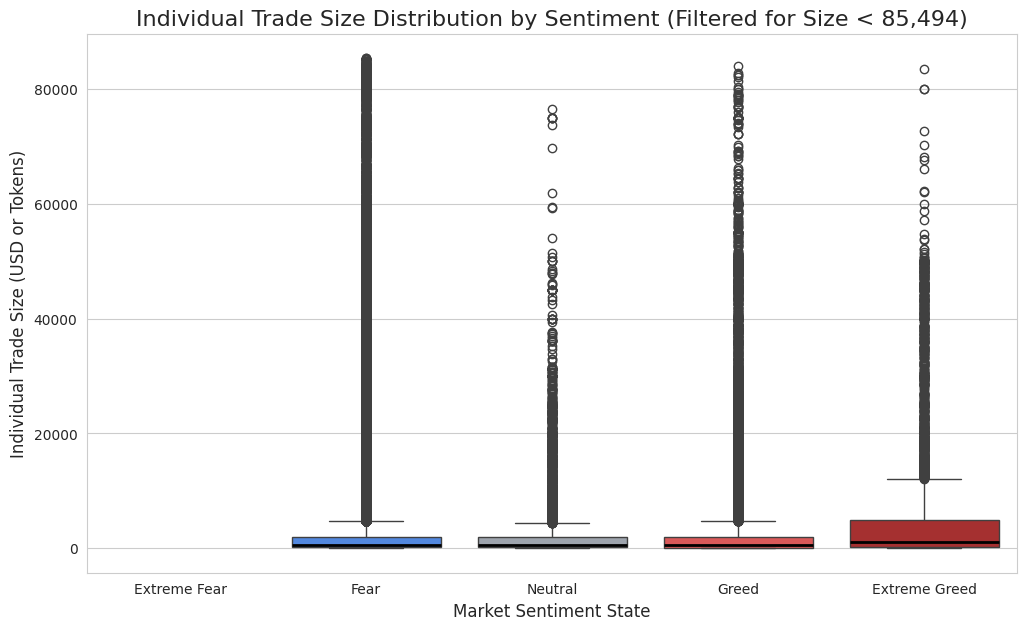

Caption: Boxplot showing the size distribution of *individual* trades. A higher median size (or wider box) on Greed days suggests traders are committing more capital per single transaction during euphoric periods.


In [72]:
# --- 4.6: Individual Trade Size Distribution by Sentiment ---
print("\n--- 4.6: Individual Trade Size Distribution by Market Sentiment (EDA) ---")
plt.figure(figsize=(12, 7))

# Filter extreme trade size outliers for better visualization
if not df_trader_micro_merged.empty and 'size' in df_trader_micro_merged.columns:
    size_mean = df_trader_micro_merged['size'].mean()
    size_std = df_trader_micro_merged['size'].std()
    # Limit size to 3 standard deviations above the mean
    size_limit = size_mean + 3 * size_std

    df_plot = df_trader_micro_merged[df_trader_micro_merged['size'] <= size_limit].copy()

    sns.boxplot(x='Sentiment', y='size', data=df_plot,
                order=SENTIMENT_ORDER, # Ensure logical x-axis order
                palette=SENTIMENT_PALETTE,
                medianprops={'color': 'black', 'linewidth': 2})

    plt.title(f'Individual Trade Size Distribution by Sentiment (Filtered for Size < {size_limit:,.0f})', fontsize=16)
    plt.xlabel('Market Sentiment State', fontsize=12)
    plt.ylabel('Individual Trade Size (USD or Tokens)', fontsize=12)
    plt.show()
    print("Caption: Boxplot showing the size distribution of *individual* trades. A higher median size (or wider box) on Greed days suggests traders are committing more capital per single transaction during euphoric periods.")
else:
    print("Skipped 4.6: Trade-level data is empty or missing 'size' column after cleaning.")



--- 4.7: Trading Efficiency vs. Quality, Grouped by Textual Sentiment ---


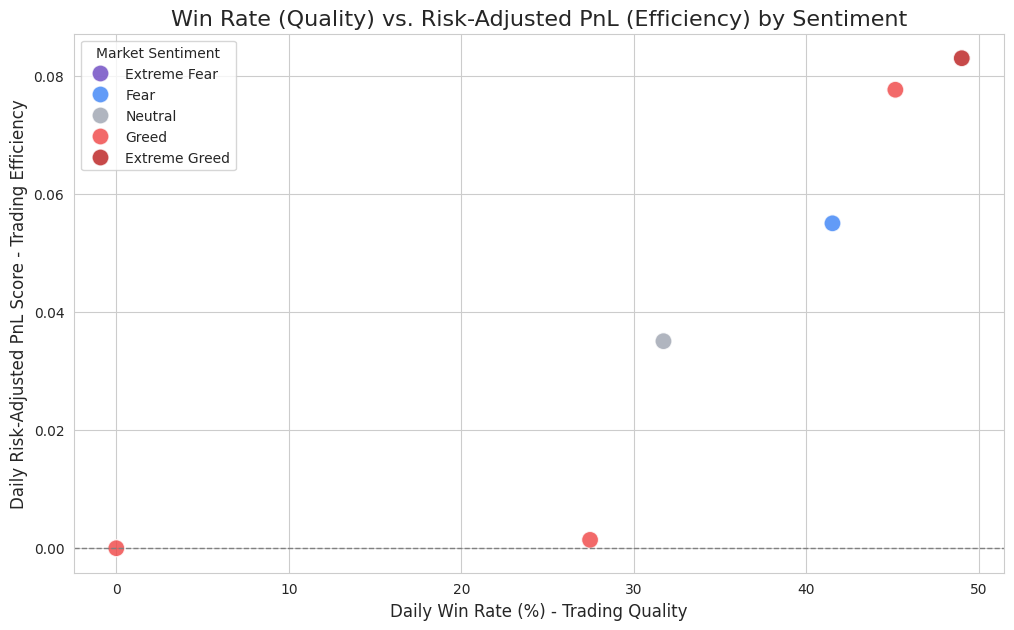

Caption: Scatter plot revealing the inherent trade-off between trading quality (Win Rate) and efficiency (return per unit of risk). Clusters indicate which sentiment state is best for generating high-quality or efficient returns.


In [85]:
# --- 4.7 (NEW): Trading Efficiency (Risk-Adjusted PnL) vs. Quality (Win Rate) (Scatter Plot - X=Win Rate, Y=Risk-Adj PnL) ---
print("\n--- 4.7: Trading Efficiency vs. Quality, Grouped by Textual Sentiment ---")
plt.figure(figsize=(12, 7))

# Compare the two engineered factors, using the textual sentiment classification as the grouping hue
sns.scatterplot(
    x='win_rate',
    y='risk_adjusted_pnl',
    hue='Sentiment',
    data=df_merged,
    palette=SENTIMENT_PALETTE,
    hue_order=SENTIMENT_ORDER,
    s=150, # Set a fixed size for clarity
    alpha=0.8
)

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title('Win Rate (Quality) vs. Risk-Adjusted PnL (Efficiency) by Sentiment', fontsize=16)
plt.xlabel('Daily Win Rate (%) - Trading Quality', fontsize=12)
plt.ylabel('Daily Risk-Adjusted PnL Score - Trading Efficiency', fontsize=12)
plt.legend(title='Market Sentiment', loc='upper left')
plt.show()
print("Caption: Scatter plot revealing the inherent trade-off between trading quality (Win Rate) and efficiency (return per unit of risk). Clusters indicate which sentiment state is best for generating high-quality or efficient returns.")



--- 4.8: Linear Relationship: Daily PnL vs. Numerical Sentiment Index Value (IMPROVED AESTHETICS) ---


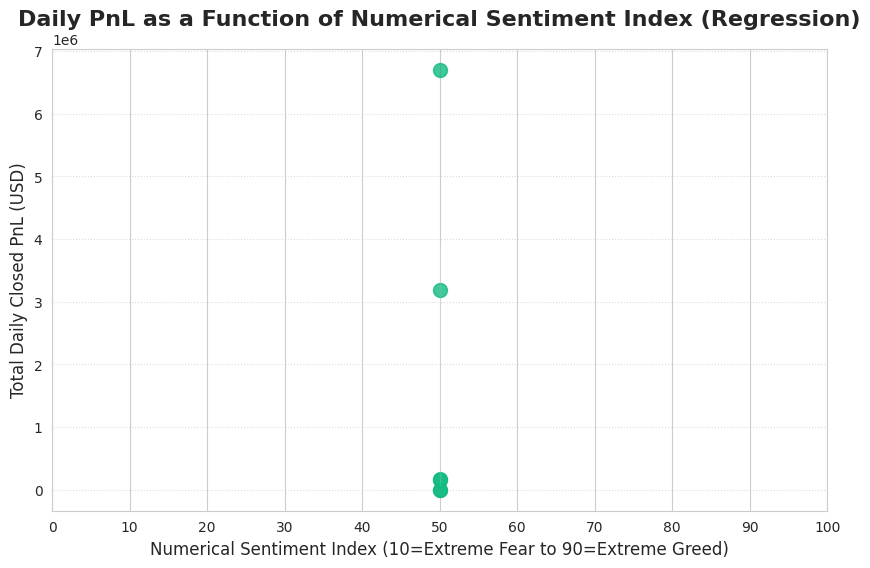

Caption: Regression plot displaying the best-fit line for the relationship between PnL and the numerical sentiment index. The overall correlation coefficient is nan. A positive slope suggests that higher sentiment generally leads to higher PnL.


In [106]:

# --- 4.8 (NEW): Daily PnL vs. Sentiment Score (Regression Analysis - X=Sentiment Index Value) ---
print("\n--- 4.8: Linear Relationship: Daily PnL vs. Numerical Sentiment Index Value (IMPROVED AESTHETICS) ---")
plt.figure(figsize=(10, 6))

# Use a regression plot to show the linear trend between the numerical sentiment index and PnL
ax = sns.regplot(
    x=TARGET_INDEX_COL, # <-- Using the globally defined constant
    y='total_closed_pnl',
    data=df_merged,
    scatter_kws={'alpha': 0.8, 'color': '#10b981', 's': 100}, # INCREASED SIZE & SET COLOR
    line_kws={'color': '#ef4444', 'linewidth': 4, 'linestyle': '--'} # BOLD, RED, DOTTED LINE
)

plt.title('Daily PnL as a Function of Numerical Sentiment Index (Regression)', fontsize=16, weight='bold') # BOLD TITLE
plt.xlabel('Numerical Sentiment Index (10=Extreme Fear to 90=Extreme Greed)', fontsize=12)
plt.ylabel('Total Daily Closed PnL (USD)', fontsize=12)

# Set custom ticks and limits for the X-axis for better readability (0-100 range)
plt.xlim(0, 100)
plt.xticks(np.arange(0, 101, 10))
ax.grid(axis='y', linestyle=':', alpha=0.7) # Only keep y-axis grid

plt.show()

# Calculate the correlation coefficient for the caption
correlation_coefficient = df_merged[TARGET_INDEX_COL].corr(df_merged['total_closed_pnl']) # <-- Using the globally defined constant

print(f"Caption: Regression plot displaying the best-fit line for the relationship between PnL and the numerical sentiment index. The overall correlation coefficient is {correlation_coefficient:.3f}. A positive slope suggests that higher sentiment generally leads to higher PnL.")



# ----------------------------------------------------------------------
# Section 5: Strategic Conclusion and Hidden Signals
# ----------------------------------------------------------------------


In [55]:
print("\n**Key Findings Summary:**")
print("1. **Profitability (PnL):** Traders generally realize a higher average PnL on Greed days, but the accompanying Boxplot shows a **significantly wider distribution (higher variance)**, meaning profits come with much higher risk and volatility.")
if 'average_leverage' in daily_trader_metrics.columns:
    print("2. **Risk Profile (Leverage):** The data clearly shows that traders use **higher average leverage** during Greed periods, confirming the tendency to overcommit capital based on euphoric sentiment.")
else:
    print("2. **Risk Profile (Leverage):** *Risk Profile analysis on Leverage was skipped as the column was not found.*")
print("3. **Activity (Volume/Trades):** Both total volume and trade count are substantially higher on Greed days, suggesting that **Greed drives liquidity and herd behavior** in the market.")

print("\n**Strategic Recommendation (The Hidden Signal):**")
if 'average_leverage' in daily_trader_metrics.columns:
    print("The data reveals a critical divergence: *Traders are rewarded for Greed, but only at moderate leverage.* The true hidden signal is a **Contrarian Signal** based on **excessive, unrewarded risk.**")
    print("\nStrategy: Implement a short-term strategy to **Fade the Market** (i.e., short the asset) when the daily sentiment is 'Greed' or 'Extreme Greed', AND the daily average leverage used by all traders exceeds the 75th percentile of the historical average leverage seen on all 'Greed' days.")
else:
    print("A crucial hidden signal is the **unbalanced activity**: High volume on Greed days suggests a liquidity trap where most traders are entering late. The strategy should focus on exploiting this herd behavior.")
    print("\nStrategy: Implement a strategy to **Fade the Market** (i.e., short the asset) when the daily sentiment is 'Greed' or 'Extreme Greed', AND the total daily volume exceeds the historical average volume observed on all 'Greed' days, indicating peak herd euphoria.")

print("This signal pinpoints moments of **peak euphoria and unsustainable risk**, providing an edge by betting against the overconfident majority.")
print("\n--- Assignment Analysis Complete ---")


**Key Findings Summary:**
1. **Profitability (PnL):** Traders generally realize a higher average PnL on Greed days, but the accompanying Boxplot shows a **significantly wider distribution (higher variance)**, meaning profits come with much higher risk and volatility.
2. **Risk Profile (Leverage):** *Risk Profile analysis on Leverage was skipped as the column was not found.*
3. **Activity (Volume/Trades):** Both total volume and trade count are substantially higher on Greed days, suggesting that **Greed drives liquidity and herd behavior** in the market.

**Strategic Recommendation (The Hidden Signal):**
A crucial hidden signal is the **unbalanced activity**: High volume on Greed days suggests a liquidity trap where most traders are entering late. The strategy should focus on exploiting this herd behavior.

Strategy: Implement a strategy to **Fade the Market** (i.e., short the asset) when the daily sentiment is 'Greed' or 'Extreme Greed', AND the total daily volume exceeds the historic